In [ ]:
#importing necessary libraries
! pip install pygad
! pip install psutil


import pygad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import psutil


# **Creating Data**

In [37]:
np.random.seed(42)  # For reproducibility

num_nodes = 10
num_sources = 3  # Solar, Hydro, Wind
hours = 24

### Demand patterns

In [38]:

base_residential = np.random.randint(30, 50, size=7)  # Residential nodes
base_industrial = np.random.randint(80, 120, size=3)  # Industrial nodes
base_demand = np.concatenate([base_residential, base_industrial])

hour_factors = np.array([
    0.5, 0.4, 0.3, 0.3, 0.4, 0.6,  # Night
    0.9, 1.2, 1.5, 1.6, 1.3, 1.2,  # Morning & Noon
    1.1, 1.0, 0.9, 0.8, 1.1, 1.4,  # Afternoon
    1.7, 1.8, 1.4, 1.0, 0.7, 0.6   # Evening
])

demand_matrix = base_demand[:, None] * hour_factors[None, :]
demand_df = pd.DataFrame(demand_matrix,
                         index=[f'Node_{i+1}' for i in range(num_nodes)],
                         columns=[f'Hour_{h}' for h in range(hours)])


### Supply patterns

In [39]:
solar_profile = np.array([0, 0, 0, 0, 50, 120, 200, 250, 300, 320, 350, 360,
                          370, 360, 320, 250, 200, 150, 50, 0, 0, 0, 0, 0])
hydro_profile = np.random.randint(250, 350, size=hours)  # stable
wind_profile = np.random.randint(50, 200, size=hours)    # fluctuating

supply_df = pd.DataFrame([solar_profile, hydro_profile, wind_profile],
                         index=['Solar', 'Hydro', 'Wind'],
                         columns=[f'Hour_{h}' for h in range(hours)])

### Transmission loss

In [40]:
transmission_loss = np.linspace(0.02, 0.10, num_nodes)  # 2% - 10%
transmission_df = pd.DataFrame(np.tile(transmission_loss, (num_sources, 1)),
                               index=['Solar', 'Hydro', 'Wind'],
                               columns=[f'Node_{i+1}' for i in range(num_nodes)])

### Preview data

In [41]:
print("Sample Demand Data:\n", demand_df.head())
print("\nSample Supply Data:\n", supply_df)
print("\nTransmission Loss Matrix:\n", transmission_df)

Sample Demand Data:
         Hour_0  Hour_1  Hour_2  Hour_3  Hour_4  Hour_5  Hour_6  Hour_7  \
Node_1    18.0    14.4    10.8    10.8    14.4    21.6    32.4    43.2   
Node_2    24.5    19.6    14.7    14.7    19.6    29.4    44.1    58.8   
Node_3    22.0    17.6    13.2    13.2    17.6    26.4    39.6    52.8   
Node_4    20.0    16.0    12.0    12.0    16.0    24.0    36.0    48.0   
Node_5    18.5    14.8    11.1    11.1    14.8    22.2    33.3    44.4   

        Hour_8  Hour_9  ...  Hour_14  Hour_15  Hour_16  Hour_17  Hour_18  \
Node_1    54.0    57.6  ...     32.4     28.8     39.6     50.4     61.2   
Node_2    73.5    78.4  ...     44.1     39.2     53.9     68.6     83.3   
Node_3    66.0    70.4  ...     39.6     35.2     48.4     61.6     74.8   
Node_4    60.0    64.0  ...     36.0     32.0     44.0     56.0     68.0   
Node_5    55.5    59.2  ...     33.3     29.6     40.7     51.8     62.9   

        Hour_19  Hour_20  Hour_21  Hour_22  Hour_23  
Node_1     64.8     50.

# **Exploratory Data Analytics**

In [42]:
#ok quick peek first

print("Demand DF:", demand_df.shape)
print("Supply DF:", supply_df.shape)
print("Transmission DF:", transmission_df.shape)

display(demand_df.head())
display(supply_df.head())
display(transmission_df.head())

Demand DF: (10, 24)
Supply DF: (3, 24)
Transmission DF: (3, 10)


,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
Node_1,18.0,14.4,10.8,10.8,14.4,21.6,32.4,43.2,54.0,57.6,...,32.4,28.8,39.6,50.4,61.2,64.8,50.4,36.0,25.2,21.6
Node_2,24.5,19.6,14.7,14.7,19.6,29.4,44.1,58.8,73.5,78.4,...,44.1,39.2,53.9,68.6,83.3,88.2,68.6,49.0,34.3,29.4
Node_3,22.0,17.6,13.2,13.2,17.6,26.4,39.6,52.8,66.0,70.4,...,39.6,35.2,48.4,61.6,74.8,79.2,61.6,44.0,30.8,26.4
Node_4,20.0,16.0,12.0,12.0,16.0,24.0,36.0,48.0,60.0,64.0,...,36.0,32.0,44.0,56.0,68.0,72.0,56.0,40.0,28.0,24.0
Node_5,18.5,14.8,11.1,11.1,14.8,22.2,33.3,44.4,55.5,59.2,...,33.3,29.6,40.7,51.8,62.9,66.6,51.8,37.0,25.9,22.2


,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
Solar,0,0,0,0,50,120,200,250,300,320,...,320,250,200,150,50,0,0,0,0,0
Hydro,337,349,273,252,271,302,251,337,279,287,...,282,325,307,271,338,298,340,308,291,341
Wind,64,100,157,104,113,180,100,184,70,122,...,63,58,139,102,179,133,141,160,57,84


,Node_1,Node_2,Node_3,Node_4,Node_5,Node_6,Node_7,Node_8,Node_9,Node_10
Solar,0.02,0.028889,0.037778,0.046667,0.055556,0.064444,0.073333,0.082222,0.091111,0.1
Hydro,0.02,0.028889,0.037778,0.046667,0.055556,0.064444,0.073333,0.082222,0.091111,0.1
Wind,0.02,0.028889,0.037778,0.046667,0.055556,0.064444,0.073333,0.082222,0.091111,0.1


In [43]:
#Summary stats
demand_stats = demand_df.describe().T
supply_stats = supply_df.describe().T
transmission_stats = transmission_df.describe().T

print("\nDemand (per hour) stats:")
display(demand_stats)

print("\nSupply (per hour per source) stats:")
display(supply_stats)

print("\nTransmission loss stats (per source → node):")
display(transmission_stats)


total_daily_demand_per_node = demand_df.sum(axis=1).sort_values(ascending=False)
total_daily_demand_per_hour = demand_df.sum(axis=0)
total_supply_per_hour = supply_df.sum(axis=0)
total_daily_supply = total_supply_per_hour.sum()
total_daily_demand = total_daily_demand_per_hour.sum()

print(f"\nTotal daily demand: {total_daily_demand:.2f}")
print(f"Total daily supply: {total_daily_supply:.2f}")
print(f"Supply / Demand ratio: {total_daily_supply/total_daily_demand:.2f}")
deficit_hours = (total_supply_per_hour < total_daily_demand_per_hour)



Demand (per hour) stats:


,count,mean,std,min,25%,50%,75%,max
Hour_0,10.0,28.60,13.003846,18.0,18.875,23.0,39.875,51.0
Hour_1,10.0,22.88,10.403076,14.4,15.100,18.4,31.900,40.8
Hour_2,10.0,17.16,7.802307,10.8,11.325,13.8,23.925,30.6
Hour_3,10.0,17.16,7.802307,10.8,11.325,13.8,23.925,30.6
Hour_4,10.0,22.88,10.403076,14.4,15.100,18.4,31.900,40.8
Hour_5,10.0,34.32,15.604615,21.6,22.650,27.6,47.850,61.2
Hour_6,10.0,51.48,23.406922,32.4,33.975,41.4,71.775,91.8
Hour_7,10.0,68.64,31.209229,43.2,45.300,55.2,95.700,122.4
Hour_8,10.0,85.80,39.011537,54.0,56.625,69.0,119.625,153.0
Hour_9,10.0,91.52,41.612306,57.6,60.400,73.6,127.600,163.2



Supply (per hour per source) stats:


,count,mean,std,min,25%,50%,75%,max
Hour_0,3.0,133.666667,178.975790,0.0,32.0,64.0,200.5,337.0
Hour_1,3.0,149.666667,179.722935,0.0,50.0,100.0,224.5,349.0
Hour_2,3.0,143.333333,137.012165,0.0,78.5,157.0,215.0,273.0
Hour_3,3.0,118.666667,126.638593,0.0,52.0,104.0,178.0,252.0
Hour_4,3.0,144.666667,113.852243,50.0,81.5,113.0,192.0,271.0
Hour_5,3.0,200.666667,92.743374,120.0,150.0,180.0,241.0,302.0
Hour_6,3.0,183.666667,76.813627,100.0,150.0,200.0,225.5,251.0
Hour_7,3.0,257.000000,76.739820,184.0,217.0,250.0,293.5,337.0
Hour_8,3.0,216.333333,127.162626,70.0,174.5,279.0,289.5,300.0
Hour_9,3.0,243.000000,106.080158,122.0,204.5,287.0,303.5,320.0



Transmission loss stats (per source → node):


,count,mean,std,min,25%,50%,75%,max
Node_1,3.0,0.020000,0.000000e+00,0.020000,0.020000,0.020000,0.020000,0.020000
Node_2,3.0,0.028889,4.249187e-18,0.028889,0.028889,0.028889,0.028889,0.028889
Node_3,3.0,0.037778,0.000000e+00,0.037778,0.037778,0.037778,0.037778,0.037778
Node_4,3.0,0.046667,0.000000e+00,0.046667,0.046667,0.046667,0.046667,0.046667
Node_5,3.0,0.055556,0.000000e+00,0.055556,0.055556,0.055556,0.055556,0.055556
Node_6,3.0,0.064444,0.000000e+00,0.064444,0.064444,0.064444,0.064444,0.064444
Node_7,3.0,0.073333,0.000000e+00,0.073333,0.073333,0.073333,0.073333,0.073333
Node_8,3.0,0.082222,0.000000e+00,0.082222,0.082222,0.082222,0.082222,0.082222
Node_9,3.0,0.091111,1.699675e-17,0.091111,0.091111,0.091111,0.091111,0.091111
Node_10,3.0,0.100000,1.699675e-17,0.100000,0.100000,0.100000,0.100000,0.100000



Total daily demand: 13556.40
Total daily supply: 13637.00
Supply / Demand ratio: 1.01



Total daily demand: 13556.40
Total daily supply: 13637.00
Supply / Demand ratio: 1.01


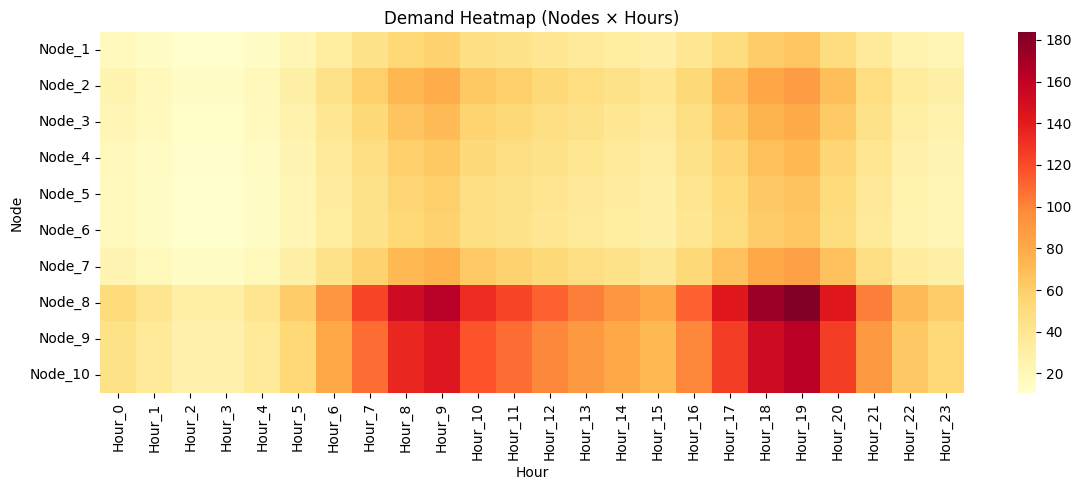

In [44]:
# Totals
total_daily_demand_per_node = demand_df.sum(axis=1).sort_values(ascending=False)
total_daily_demand_per_hour = demand_df.sum(axis=0)
total_supply_per_hour = supply_df.sum(axis=0)
total_daily_supply = total_supply_per_hour.sum()
total_daily_demand = total_daily_demand_per_hour.sum()

print(f"\nTotal daily demand: {total_daily_demand:.2f}")
print(f"Total daily supply: {total_daily_supply:.2f}")
print(f"Supply / Demand ratio: {total_daily_supply/total_daily_demand:.2f}")

# ---------------------------

# Demand heatmap (nodes × hours)
plt.figure(figsize=(12, 5))
sns.heatmap(demand_df, cmap="YlOrRd")
plt.title("Demand Heatmap (Nodes × Hours)")
plt.xlabel("Hour")
plt.ylabel("Node")
plt.tight_layout()
plt.show()

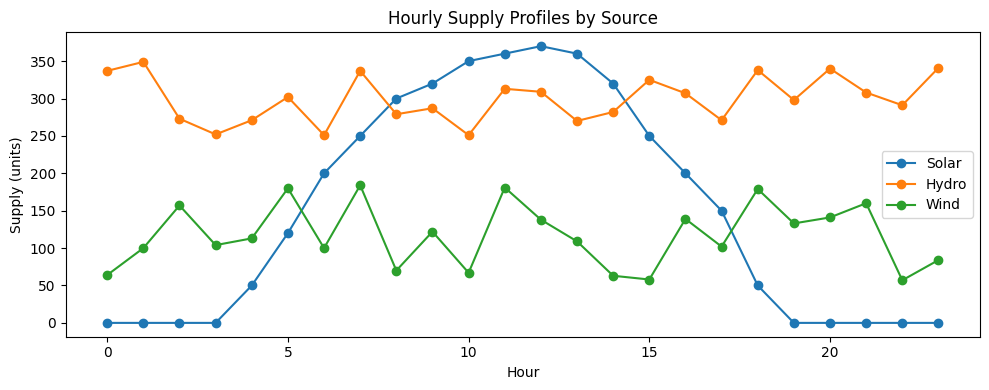

In [45]:
# ---------------------------
# Supply profiles by source
plt.figure(figsize=(10, 4))
for src in supply_df.index:
    plt.plot(range(24), supply_df.loc[src], marker='o', label=src)
plt.title("Hourly Supply Profiles by Source")
plt.xlabel("Hour")
plt.ylabel("Supply (units)")
plt.legend()
plt.tight_layout()
plt.show()


In [46]:
# Peak hour per node
peak_hour_per_node = demand_df.idxmax(axis=1)
peak_value_per_node = demand_df.max(axis=1)
node_peaks = pd.DataFrame({"peak_hour": peak_hour_per_node, "peak_value": peak_value_per_node})
print("\nPeak demand hour & value per node:")
display(node_peaks.sort_values("peak_value", ascending=False))


Peak demand hour & value per node:


,peak_hour,peak_value
Node_8,Hour_19,183.6
Node_9,Hour_19,162.0
Node_10,Hour_19,162.0
Node_2,Hour_19,88.2
Node_7,Hour_19,86.4
Node_3,Hour_19,79.2
Node_4,Hour_19,72.0
Node_5,Hour_19,66.6
Node_1,Hour_19,64.8
Node_6,Hour_19,64.8


In [47]:

#  KPIs summary table (for report)
kpis = pd.DataFrame({
    "total_daily_demand": [total_daily_demand],
    "total_daily_supply": [total_daily_supply],
    "supply_demand_ratio": [total_daily_supply / total_daily_demand],
    "num_deficit_hours": [deficit_hours.sum()],
    "max_hourly_demand": [total_daily_demand_per_hour.max()],
    "max_hourly_supply": [total_supply_per_hour.max()],
    "peak_demand_hour": [total_daily_demand_per_hour.idxmax()],
    "peak_supply_hour": [total_supply_per_hour.idxmax()]
})
print("\n=== KPIs ===")
display(kpis)


=== KPIs ===


,total_daily_demand,total_daily_supply,supply_demand_ratio,num_deficit_hours,max_hourly_demand,max_hourly_supply,peak_demand_hour,peak_supply_hour
0,13556.4,13637,1.005946,9,1029.6,854,Hour_19,Hour_11


# **Configurations for GA**

In [48]:
# Costs per unit (MWh) for Solar, Hydro, Wind
costs = np.array([25, 18, 32])  # Example values

# Dimensions for GA
S = len(supply_df.index)   # 3 sources
N = len(demand_df.index)   # 10 nodes
T = len(demand_df.columns) # 24 hours

In [49]:
# GA dimensions
num_genes = S * N * T  # total genes per chromosome

# GA settings
num_generations = 100
population_size = 50
mutation_rate = 10

## Fitness function

In [50]:
def fitness_function(ga_instance, solution, solution_idx):

    # Reshaping 1D chromosome to (sources, nodes, hours)
    X = solution.reshape(S, N, T)

    # 1. Total cost of energy
    total_cost = np.sum(costs[:, None, None] * X)


    # 2. Transmission loss
    # (energy lost per source->node, multiplied by allocated energy)
    total_loss = np.sum(transmission_df.to_numpy()[:, :, None] * (X ** 2))


    # Demand deviation (unmet demand)
    supplied = np.sum(X, axis=0)  # total supply to each node per hour (N, T)
    demand_array = demand_df.to_numpy()
    demand_deviation = np.sum(np.abs(demand_array - supplied))

    # Capacity violations (per source per hour)
    supply_array = supply_df.to_numpy()  # (S, T)
    source_hourly_usage = np.sum(X, axis=1)  # (S, T)
    capacity_violation = np.sum(np.maximum(0, source_hourly_usage - supply_array))


    # Combining into fitness
    w_cost = 1.0
    w_loss = 2.0
    w_demand = 5.0
    penalty = 1000.0

    fitness = -(
        w_cost * total_cost +
        w_loss * total_loss +
        w_demand * demand_deviation +
        penalty * capacity_violation
    )

    return fitness


In [51]:
# Preparing demand and transmission arrays
demands = demand_df.to_numpy()
losses = transmission_df.to_numpy()
capacities = supply_df.sum(axis=1).to_numpy()  # total available per source (S,)

def evaluate_solution(allocation):
    """Evaluate allocation and return metrics"""
    total_cost = np.sum(costs[:, None, None] * allocation)
    total_loss = np.sum(losses[:, :, None] * allocation ** 2)
    supplied = np.sum(allocation, axis=0)
    demand_deviation = np.sum(np.abs(demands - supplied))
    source_usage = np.sum(allocation, axis=(1, 2))
    capacity_violation = np.sum(np.maximum(0, source_usage - capacities))
    fitness = -(
        1.0 * total_cost +
        2.0 * total_loss +
        5.0 * demand_deviation +
        1000.0 * capacity_violation
    )
    return {
        'fitness': fitness,
        'cost': total_cost,
        'loss': total_loss,
        'demand_deviation': demand_deviation,
        'capacity_violation': capacity_violation
    }


# **Baselines Algorithms for Comparisons**

### Greedy Baseline

In [52]:
def greedy_baseline():
    allocation = np.zeros((S, N, T))
    source_order = np.argsort(costs)  # Use cheapest source first

    for t in range(T):
        for n in range(N):
            demand = demands[n, t]
            for s in source_order:
                if demand <= 0:
                    break
                used = np.sum(allocation[s, :, t])
                available = capacities[s] - used
                give = min(demand, max(0, available))
                allocation[s, n, t] = give
                demand -= give
    return allocation

### Rule Based Baseline

In [53]:
def rule_based_baseline():
    allocation = np.zeros((S, N, T))
    efficiency = capacities / costs
    proportions = efficiency / np.sum(efficiency)

    for t in range(T):
        for n in range(N):
            demand = demands[n, t]
            for s in range(S):
                used = np.sum(allocation[s, :, t])
                available = capacities[s] - used
                give = min(demand * proportions[s], max(0, available))
                allocation[s, n, t] = give
    return allocation


In [54]:
# Greedy
start = time.time()
greedy_alloc = greedy_baseline()
greedy_time = time.time() - start
greedy_metrics = evaluate_solution(greedy_alloc)
greedy_metrics["execution_time"] = greedy_time

# Rule-based
start = time.time()
rule_alloc = rule_based_baseline()
rule_time = time.time() - start
rule_metrics = evaluate_solution(rule_alloc)
rule_metrics["execution_time"] = rule_time

# Results
print(f"\nGreedy Baseline - Fitness: {greedy_metrics['fitness']:.2f}, Time: {greedy_time:.4f}s")
print(f"Rule-Based Baseline - Fitness: {rule_metrics['fitness']:.2f}, Time: {rule_time:.4f}s")



Greedy Baseline - Fitness: -6785435.19, Time: 0.0035s
Rule-Based Baseline - Fitness: -1738415.81, Time: 0.0068s


In [55]:
print(f"- Generations: {num_generations}")
print(f"- Population Size: {population_size}")
print(f"- Mutation Rate: {mutation_rate}%")
print(f"- Chromosome Length: {num_genes}")

- Generations: 100
- Population Size: 50
- Mutation Rate: 10%
- Chromosome Length: 720


# **GENETIC ALGORITHM IMPLEMENTATION**

## Serial Implementation

In [56]:
ga_serial = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=10,
    fitness_func=fitness_function,
    sol_per_pop=population_size,
    num_genes=num_genes,
    gene_type=float,
    init_range_low=0.0,
    init_range_high=15.0,
    mutation_percent_genes=mutation_rate,
    random_seed=42
)

import time
start_time = time.time()
ga_serial.run()
serial_time = time.time() - start_time

# Results
serial_solution, serial_fitness, _ = ga_serial.best_solution()
serial_allocation = serial_solution.reshape(S, N, T)
serial_metrics = evaluate_solution(serial_allocation)
serial_metrics["execution_time"] = serial_time

print(f"Serial GA - Fitness: {serial_fitness:.2f}, Time: {serial_time:.4f}s")


Serial GA - Fitness: -425893.97, Time: 17.4291s


### Parallel implementation

In [57]:
print("\n Running Parallel GA with 2 Threads")

ga_parallel = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=10,
    fitness_func=fitness_function,
    sol_per_pop=population_size,
    num_genes=num_genes,
    gene_type=float,
    init_range_low=0.0,
    init_range_high=15.0,
    mutation_percent_genes=mutation_rate,
    random_seed=42,
    parallel_processing=["thread", 2]  # 2 threads for parallel execution
)

start_time = time.time()
ga_parallel.run()
parallel_time = time.time() - start_time

# Results
parallel_solution, parallel_fitness, _ = ga_parallel.best_solution()
parallel_allocation = parallel_solution.reshape(S, N, T)
parallel_metrics = evaluate_solution(parallel_allocation)
parallel_metrics["execution_time"] = parallel_time

# Speedup calculation
speedup = serial_time / parallel_time

print(f"✓ Parallel GA - Fitness: {parallel_fitness:.2f}, Time: {parallel_time:.4f}s")
print(f"✓ Speedup Factor: {speedup:.2f}x faster than serial")



 Running Parallel GA with 2 Threads
✓ Parallel GA - Fitness: -425893.97, Time: 10.0198s
✓ Speedup Factor: 1.74x faster than serial


In [58]:
# Serial GA best fitness generation
best_gen_serial = np.argmax(ga_serial.best_solutions_fitness)
best_fit_serial = ga_serial.best_solutions_fitness[best_gen_serial]

print(f"Serial GA - Best fitness at generation {best_gen_serial}: {best_fit_serial:.2f}")

# Parallel GA best fitness generation
best_gen_parallel = np.argmax(ga_parallel.best_solutions_fitness)
best_fit_parallel = ga_parallel.best_solutions_fitness[best_gen_parallel]

print(f"Parallel GA - Best fitness at generation {best_gen_parallel}: {best_fit_parallel:.2f}")


Serial GA - Best fitness at generation 100: -425893.97
Parallel GA - Best fitness at generation 100: -425893.97


### For test parameters

In [59]:
def test_parameters(pop_sizes, mutation_rates):
    """Test different combinations of population size and mutation rate."""
    results = []
    total_tests = len(pop_sizes) * len(mutation_rates)
    test_num = 1

    for pop in pop_sizes:
        for mut in mutation_rates:
            print(f"Test {test_num}/{total_tests}: Pop={pop}, Mutation={mut}% ... ", end="")
            test_num += 1

            ga_test = pygad.GA(
                num_generations=50,  # Keeping fewer generations for speed
                num_parents_mating=max(2, pop // 5),
                fitness_func=fitness_function,
                sol_per_pop=pop,
                num_genes=num_genes,
                gene_type=float,
                init_range_low=0.0,
                init_range_high=15.0,
                mutation_percent_genes=mut,
                random_seed=42
            )

            start = time.time()
            ga_test.run()
            duration = time.time() - start

            _, best_fitness, _ = ga_test.best_solution()

            results.append({
                "population_size": pop,
                "mutation_rate": mut,
                "fitness": best_fitness,
                "execution_time": duration
            })

            print(f"Fitness: {best_fitness:.2f}, Time: {duration:.2f}s")

    return pd.DataFrame(results)

In [60]:
pop_sizes = [20, 50, 100]
mutation_rates = [5, 10, 20]

print("\nRunning Parameter Sensitivity Analysis")
param_results = test_parameters(pop_sizes, mutation_rates)


Running Parameter Sensitivity Analysis
Test 1/9: Pop=20, Mutation=5% ... Fitness: -733918.61, Time: 0.91s
Test 2/9: Pop=20, Mutation=10% ... Fitness: -670402.46, Time: 1.68s
Test 3/9: Pop=20, Mutation=20% ... Fitness: -621532.47, Time: 3.27s
Test 4/9: Pop=50, Mutation=5% ... Fitness: -677106.31, Time: 2.85s
Test 5/9: Pop=50, Mutation=10% ... Fitness: -592649.82, Time: 4.29s
Test 6/9: Pop=50, Mutation=20% ... Fitness: -512990.02, Time: 9.38s
Test 7/9: Pop=100, Mutation=5% ... Fitness: -592151.72, Time: 4.73s
Test 8/9: Pop=100, Mutation=10% ... Fitness: -543942.60, Time: 9.30s
Test 9/9: Pop=100, Mutation=20% ... Fitness: -460021.70, Time: 19.36s


In [61]:
def monitor_and_run(ga_instance):
    cpu_usage = []
    mem_usage = []
    timestamps = []

    def monitor():
        for _ in range(ga_instance.num_generations):
            cpu = psutil.cpu_percent(interval=0.1)
            mem = psutil.virtual_memory().percent
            cpu_usage.append(cpu)
            mem_usage.append(mem)
            timestamps.append(time.time())

    import threading
    monitor_thread = threading.Thread(target=monitor)
    monitor_thread.start()

    start_time = time.time()
    ga_instance.run()
    duration = time.time() - start_time

    monitor_thread.join()
    return cpu_usage, mem_usage, timestamps, duration

In [62]:
print("Monitoring Serial GA...")
cpu_serial, mem_serial, time_serial, serial_runtime = monitor_and_run(ga_serial)

print("Monitoring Parallel GA...")
cpu_parallel, mem_parallel, time_parallel, parallel_runtime = monitor_and_run(ga_parallel)

Monitoring Serial GA...
Monitoring Parallel GA...


# **Visualizing GA performance**

### Convergence of GA (Fitness over Generations)

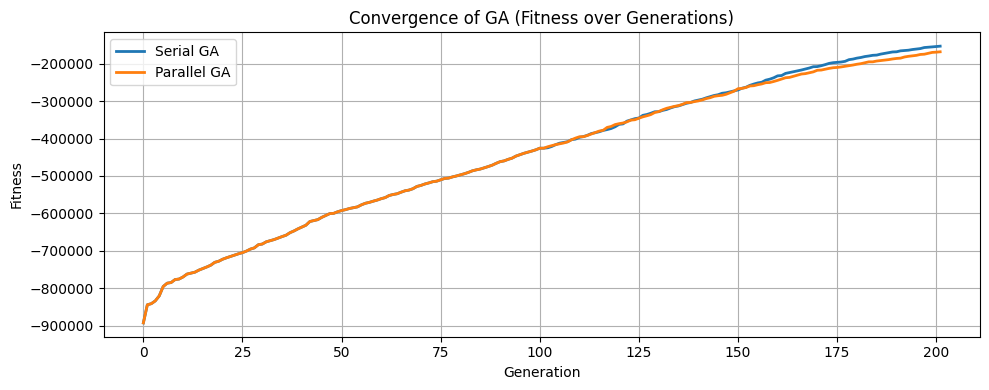

In [63]:
plt.figure(figsize=(10, 4))
plt.plot(ga_serial.best_solutions_fitness, label="Serial GA", linewidth=2)
plt.plot(ga_parallel.best_solutions_fitness, label="Parallel GA", linewidth=2)
plt.title("Convergence of GA (Fitness over Generations)")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

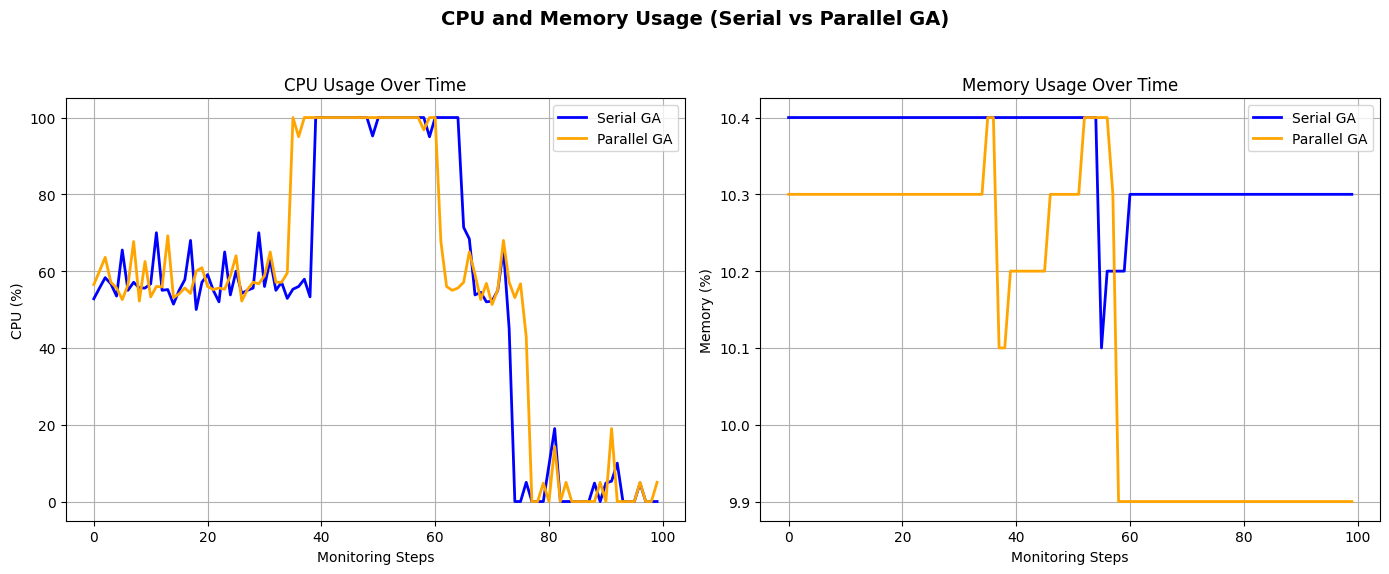

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("CPU and Memory Usage (Serial vs Parallel GA)", fontsize=14, fontweight='bold')

# 1. CPU Usage
axes[0].plot(cpu_serial, label='Serial GA', color='blue', linewidth=2)
axes[0].plot(cpu_parallel, label='Parallel GA', color='orange', linewidth=2)
axes[0].set_title("CPU Usage Over Time")
axes[0].set_xlabel("Monitoring Steps")
axes[0].set_ylabel("CPU (%)")
axes[0].legend()
axes[0].grid(True)

# 2. Memory Usage
axes[1].plot(mem_serial, label='Serial GA', color='blue', linewidth=2)
axes[1].plot(mem_parallel, label='Parallel GA', color='orange', linewidth=2)
axes[1].set_title("Memory Usage Over Time")
axes[1].set_xlabel("Monitoring Steps")
axes[1].set_ylabel("Memory (%)")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit suptitle
plt.show()


### Execcution time comparsion

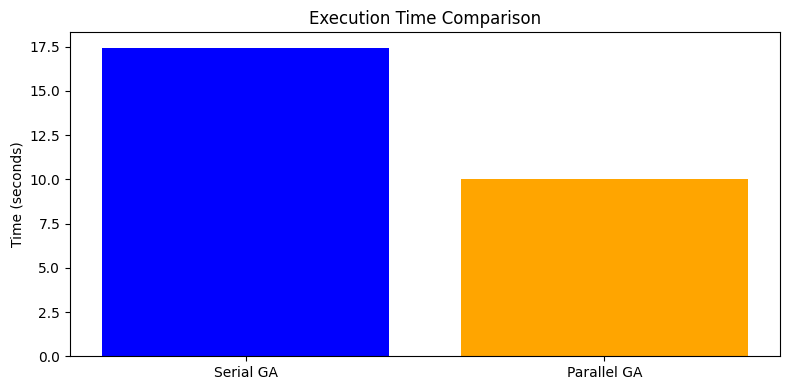

In [67]:
methods = ["Serial GA", "Parallel GA"]
times = [serial_metrics["execution_time"], parallel_metrics["execution_time"]]

plt.figure(figsize=(8, 4))
plt.bar(methods, times, color=["blue", "orange"])
plt.title("Execution Time Comparison")
plt.ylabel("Time (seconds)")
plt.tight_layout()
plt.show()

### Fitness comparison

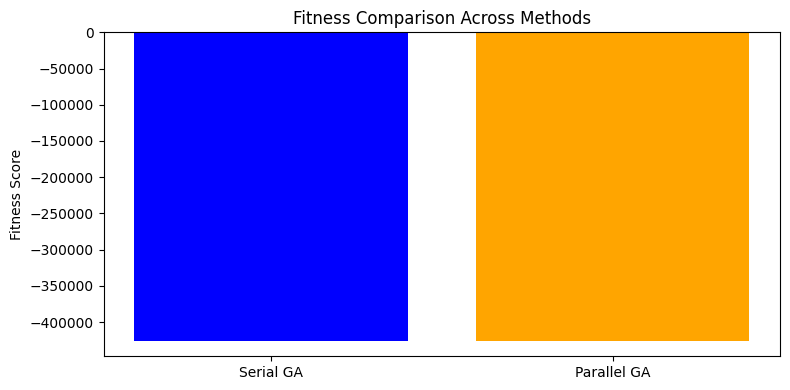

In [69]:
fitnesses = [serial_fitness, parallel_fitness]

plt.figure(figsize=(8, 4))
plt.bar(methods, fitnesses, color=["blue", "orange"])
plt.title("Fitness Comparison Across Methods")
plt.ylabel("Fitness Score")
plt.tight_layout()
plt.show()

### Effect of population Size on fitness

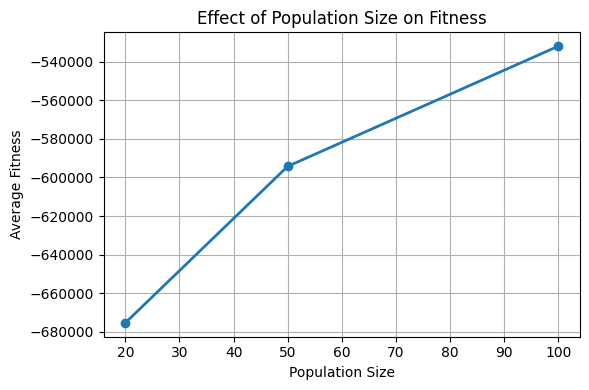

In [70]:
plt.figure(figsize=(6, 4))
param_results.groupby("population_size")["fitness"].mean().plot(marker="o", linewidth=2)
plt.title("Effect of Population Size on Fitness")
plt.xlabel("Population Size")
plt.ylabel("Average Fitness")
plt.grid(True)
plt.tight_layout()
plt.show()


### Effect of mutation Rate on Fitness

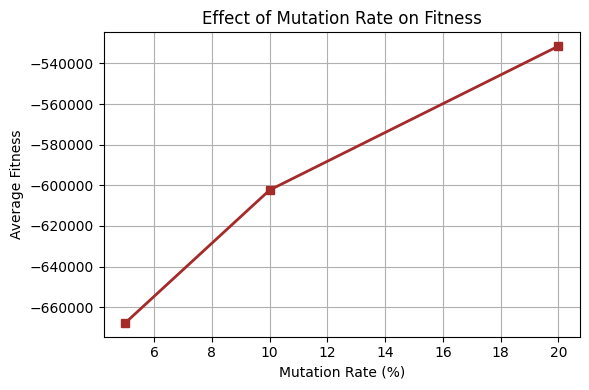

In [71]:
plt.figure(figsize=(6, 4))
param_results.groupby("mutation_rate")["fitness"].mean().plot(marker="s", color="brown", linewidth=2)
plt.title("Effect of Mutation Rate on Fitness")
plt.xlabel("Mutation Rate (%)")
plt.ylabel("Average Fitness")
plt.grid(True)
plt.tight_layout()
plt.show()


### Total Energy Allocacted

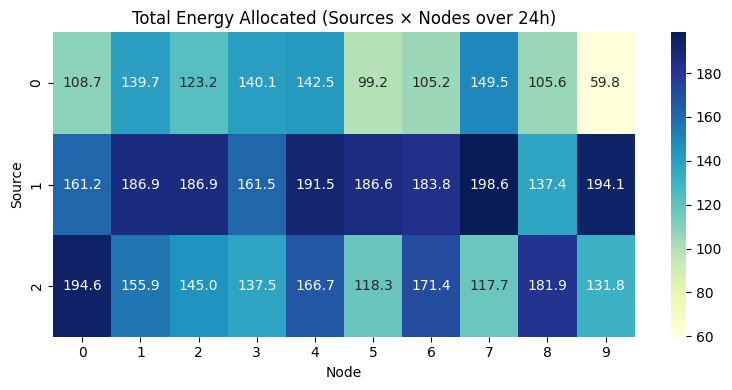

In [72]:
allocation = parallel_allocation  # Best from parallel GA
allocation_total = np.sum(allocation, axis=2)  # total over time

plt.figure(figsize=(8, 4))
sns.heatmap(allocation_total, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Total Energy Allocated (Sources × Nodes over 24h)")
plt.xlabel("Node")
plt.ylabel("Source")
plt.tight_layout()
plt.show()


# **FINAL RESULT SUMMARY**

In [73]:
print("=" * 50)
print(f"{'Method':<15} {'Fitness':<12} {'Cost($)':<10} {'Loss':<10} {'Time(s)':<10}")
print("-" * 50)
print(f"{'Serial GA':<15} {serial_fitness:<12.2f} {serial_metrics['cost']:<10.1f} {serial_metrics['loss']:<10.2f} {serial_metrics['execution_time']:<10.4f}")
print(f"{'Parallel GA':<15} {parallel_fitness:<12.2f} {parallel_metrics['cost']:<10.1f} {parallel_metrics['loss']:<10.2f} {parallel_metrics['execution_time']:<10.4f}")
print(f"{'Greedy':<15} {greedy_metrics['fitness']:<12.2f} {greedy_metrics['cost']:<10.1f} {greedy_metrics['loss']:<10.2f} {greedy_metrics['execution_time']:<10.4f}")
print(f"{'Rule-based':<15} {rule_metrics['fitness']:<12.2f} {rule_metrics['cost']:<10.1f} {rule_metrics['loss']:<10.2f} {rule_metrics['execution_time']:<10.4f}")


Method          Fitness      Cost($)    Loss       Time(s)   
--------------------------------------------------
Serial GA       -425893.97   110192.0   2622.19    17.4291   
Parallel GA     -425893.97   110192.0   2622.19    10.0198   
Greedy          -6785435.19  244015.2   83510.00   0.0035    
Rule-based      -1738415.81  292210.2   39266.65   0.0068    
